# Imports, Configs and Datasets

In [1]:
import torch
from torch import nn, optim
import torchinfo # This library is used to get the summary of the model
import torchvision # This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [2]:
config = {
    'batch_size': 512, # Increase this if your GPU can handle it
    'epochs': 120,
    'initialized': False,
    'init_lr'       : 0.02,
    'weight_decay'  : 1e-5,
    'smoothing_factor': 0.1,
    'continue_training': True,
    'last_epoch': 39,
}

def init_config(model, notes=""):
    strict = False
    if not config['initialized']:
        config['model_name'] = f"{model.describe()}_bs_{config['batch_size']}_{notes}"
        config['initialized'] = True
    else:
        if strict: raise Exception("Config already initialized")

In [3]:
# --------------------------------------------------- #

# Data paths
DATA_ROOT = "/mnt/e/Workspace/IDL/Data/hw2/11-785-s24-hw2p2-classification" # Local root for kaggle data
DATA_DIR    = DATA_ROOT 
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# --------------------------------------------------- #

# Transformations/augmentations of the Train dataset


train_transforms_plain = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ]) 

train_transforms_1 = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.ColorJitter(),
    # torchvision.transforms.RandomPerspective(),
    torchvision.transforms.ToTensor()
    ])
# --------------------------------------------------- #

# Transformations/augmentations of the Val dataset


valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ]) # TODO: Specify transformations performed on the val dataset

# --------------------------------------------------- #

# Initializing the train and val datasets

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms_1)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform = valid_transforms)

# --------------------------------------------------- #

# Initializing the train and val dataloaders

train_loader = torch.utils.data.DataLoader(dataset       = train_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = True,
                                           num_workers = 16, # Uncomment this line if you want to increase your num workers
                                           pin_memory    = True)

valid_loader = torch.utils.data.DataLoader(dataset       = valid_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = False,
                                           num_workers = 4 # Uncomment this line if you want to increase your num workers
                                           )

In [4]:
# --------------------------------------------------- #

# Test dataset class

class TestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

# --------------------------------------------------- #

# Initializing the test dataset

"""
Why are we using val_transforms for Test Data?
"""

test_dataset = TestDataset(TEST_DIR, transforms = valid_transforms)

# --------------------------------------------------- #

# Initializing the test dataloader

test_loader = torch.utils.data.DataLoader(dataset    = test_dataset,
                                          batch_size = config['batch_size'],
                                          shuffle     = False,
                                          drop_last  = False,
                                          num_workers = 8 # Uncomment this line if you want to increase your num workers
                                          )

In [5]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

num_classes_train = len(train_dataset.classes)

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  512
Train batches        :  274
Val batches          :  69


torch.Size([512])


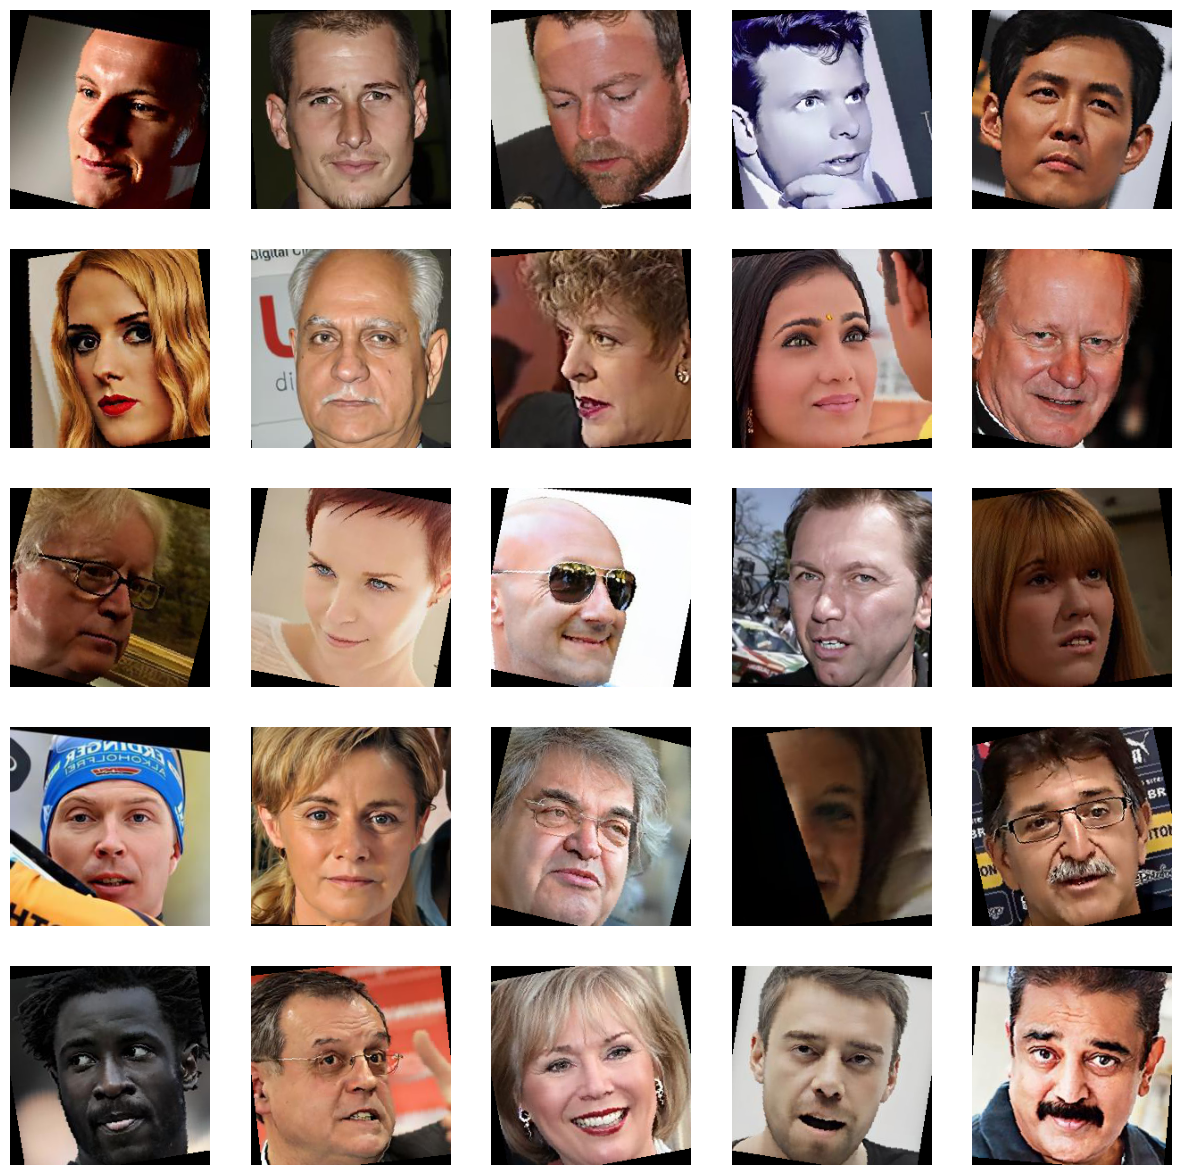

In [6]:
r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0

# dtl     = torch.utils.data.DataLoader(
#     dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms_1), # dont wanna see the images with transforms
#     batch_size  = config['batch_size'],
#     shuffle     = True)

for data in train_loader:
    x, y = data
    print(y.shape)

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

# del dtl

# Model Architectures

In [7]:
from torchvision import models
class TorchResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(pretrained=False)
        self.interm_features = self.model.fc.in_features
        self.model.fc = nn.Linear(self.interm_features, num_classes)
        self._init_weights()

    def forward(self, x, return_feats=False):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        x = self.model.avgpool(x)
        if return_feats:
            return x
        else :
            x = torch.flatten(x, 1)
            return self.model.fc(x)
    
    def describe(self):
        return "tResNet18"
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
  
    
# model = TorchResNet18(num_classes_train).to(DEVICE)
# torchinfo.summary(model, input_size=(config['batch_size'], 3, 224, 224))

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, ):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

# Traning and Validation
## classification loss, criterion, sched 

In [9]:
model = TorchResNet18(num_classes_train).to(DEVICE)
init_config(model, "initial")

criterion = nn.CrossEntropyLoss(label_smoothing=config['smoothing_factor'])

optimizer = torch.optim.Adam(model.parameters(), lr= config['init_lr'], weight_decay=config['weight_decay'])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience=5, 
    min_lr=1e-8, 
    factor=0.2,
    verbose=True
)

scaler = torch.cuda.amp.GradScaler()

print(optimizer.param_groups[0]['lr'])
torchinfo.summary(model, input_size=(config['batch_size'], 3, 224, 224))

/home/zzy/miniconda3/envs/11785/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zzy/miniconda3/envs/11785/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


0.02


Layer (type:depth-idx)                        Output Shape              Param #
TorchResNet18                                 [512, 7001]               --
├─ResNet: 1-1                                 --                        --
│    └─Conv2d: 2-1                            [512, 64, 112, 112]       9,408
│    └─BatchNorm2d: 2-2                       [512, 64, 112, 112]       128
│    └─ReLU: 2-3                              [512, 64, 112, 112]       --
│    └─MaxPool2d: 2-4                         [512, 64, 56, 56]         --
│    └─Sequential: 2-5                        [512, 64, 56, 56]         --
│    │    └─BasicBlock: 3-1                   [512, 64, 56, 56]         73,984
│    │    └─BasicBlock: 3-2                   [512, 64, 56, 56]         73,984
│    └─Sequential: 2-6                        [512, 128, 28, 28]        --
│    │    └─BasicBlock: 3-3                   [512, 128, 28, 28]        230,144
│    │    └─BasicBlock: 3-4                   [512, 128, 28, 28]        295,42

## Classification

In [10]:
def train(model, dataloader, optimizer, criterion, logger, log_freq=100):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        if (i+1)%log_freq == 0:
                logger(i, total_loss / (i+1), num_correct * 100 / (config['batch_size'] * (i+1)))

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [11]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [12]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

## Verification Task

In [13]:
VER_ROOT = "/mnt/e/Workspace/IDL/Data/hw2/11-785-s24-hw2p2-verification"

# This obtains the list of known identities from the known folder
known_regex = f"{VER_ROOT}/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = f"{VER_ROOT}/unknown_dev/*"
unknown_test_regex = f"{VER_ROOT}/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 1006.46it/s]


In [14]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    #TODO: Why embeddings are 1-D?
    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy().flatten(), predictions.cpu().numpy().flatten()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    # threshold = # Choose a proper threshold
    # NO_CORRESPONDENCE_LABEL = 'n000000'
    # pred_id_strings = []
    # for idx, prediction in enumerate(predictions):
    #     if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
    #         pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
    #     else:
    #         pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      true_ids = pd.read_csv(f'{VER_ROOT}/verification_dev.csv')['label'].tolist()
      accuracy = 100 * accuracy_score(pred_id_strings, true_ids)
      #print("Verification Accuracy = {}".format(accuracy))
      return accuracy, pred_id_strings

    elif mode == 'test':
      return pred_id_strings


In [15]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Experiment
## Wandb

In [16]:
MODEL_ROOT = "/mnt/e/Workspace/IDL/Models/hw2/11-785-s24-hw2p2-classification/resnet18_1"
if not os.path.exists(MODEL_ROOT):
    os.makedirs(MODEL_ROOT)

wandb.login(key="a07bacf1f6490c2d1a0d4e22dd08701319310f93") 


run = wandb.init(
        name    = config['model_name'], ### Wandb creates random run names if you skip this field, we recommend you give useful names
        reinit  = True, ### Allows reinitalizing runs when you re-run this cell
        #id     = "y28t31uz", ### Insert specific run id here if you want to resume a previous run
        #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
        project = "hw2p2", ### Project should be created in your wandb account
        config  = config, ### Wandb Config for your run
        dir = MODEL_ROOT ### Wandb local directory
    )

# ### Save your model architecture as a string with str(model)
model_arch  = str(model)

# ### Save it in a txt file
arch_file   = open(f"{MODEL_ROOT}/model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

# ### log it in your wandb run with wandb.save()
wandb.save(arch_file.name)

def wandb_logger(iter, loss, acc):
    wandb.log({"train_loss": loss, "train_acc": acc})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: zzyatcmu (school_stuff). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/zzy/.netrc


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


## Training

In [17]:
torch.cuda.empty_cache()
gc.collect()
wandb.watch(model, log="all")


best_class_acc      = 0.0
best_ver_acc        = 0.0

#Continue training
if config['continue_training']:
    last_epoch = config['last_epoch']
    model.load_state_dict(torch.load(f"{MODEL_ROOT}/model_{last_epoch}.pth"))
    initial_epoch = last_epoch + 1
    print(f"Loaded model from epoch {last_epoch}")
    scheduler.last_epoch = initial_epoch
else:
    initial_epoch = 0

for epoch in range(config['epochs']):
    if epoch < initial_epoch:
        continue
    
    # ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
    #                                              model, similarity_metric, config['batch_size'], mode='val')

    # print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion, wandb_logger) # TODO: What function would you want implement here

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion) # TODO: What function would you want implement here
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))
    
    scheduler.step(val_loss)

    wandb.log({"train_classification_acc": train_acc,
               "train_classification_loss":train_loss,
               "val_classification_acc": val_acc,
               "val_classification_loss": val_loss,
               "val_verification_acc": ver_acc,
               "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,
    # How will you step your scheduler ?
    
    torch.save(model.state_dict(), f'{MODEL_ROOT}/model_{epoch}.pth')
    
    if val_acc >= best_class_acc:
        best_class_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, f'{MODEL_ROOT}/checkpoint_classification.pth')
        wandb.save('checkpoint_verification.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, f'{MODEL_ROOT}/checkpoint_verification.pth')
      wandb.save('checkpoint_verification.pth')
      print("Saved verification model")

### Finish your wandb run
run.finish()

Loaded model from epoch 39



Epoch 41/120: 
Train Acc (Classification) 55.1081%	 Train Loss (Classification) 3.7327	 Learning Rate 0.0200


Val Acc (Classification) 46.3938%	 Val Loss (Classification) 4.1016


Val Acc (Verification) 4.1667%	 
Saved best classification model
Saved verification model



Epoch 42/120: 
Train Acc (Classification) 59.2652%	 Train Loss (Classification) 3.5515	 Learning Rate 0.0200


Val Acc (Classification) 43.8010%	 Val Loss (Classification) 4.2643


Val Acc (Verification) 1.1111%	 



Epoch 43/120: 
Train Acc (Classification) 59.3051%	 Train Loss (Classification) 3.5460	 Learning Rate 0.0200


Val Acc (Classification) 43.9510%	 Val Loss (Classification) 4.2602


Val Acc (Verification) 3.0556%	 



Epoch 44/120: 
Train Acc (Classification) 59.6124%	 Train Loss (Classification) 3.5296	 Learning Rate 0.0200


Val Acc (Classification) 44.7294%	 Val Loss (Classification) 4.1860


Val Acc (Verification) 1.9444%	 



Epoch 45/120: 
Train Acc (Classification) 60.0151%	 Train Loss (Classification) 3.5123	 Learning Rate 0.0200


Val Acc (Classification) 47.0845%	 Val Loss (Classification) 4.1103


Val Acc (Verification) 3.0556%	 
Saved best classification model



Epoch 46/120: 
Train Acc (Classification) 60.2938%	 Train Loss (Classification) 3.4979	 Learning Rate 0.0200


Val Acc (Classification) 47.3307%	 Val Loss (Classification) 4.1019


Val Acc (Verification) 2.2222%	 
Saved best classification model



Epoch 47/120: 
Train Acc (Classification) 60.4250%	 Train Loss (Classification) 3.4923	 Learning Rate 0.0200


Val Acc (Classification) 48.4601%	 Val Loss (Classification) 4.0746


Val Acc (Verification) 3.3333%	 
Saved best classification model



Epoch 48/120: 
Train Acc (Classification) 60.6303%	 Train Loss (Classification) 3.4804	 Learning Rate 0.0200


Val Acc (Classification) 41.7204%	 Val Loss (Classification) 4.3788


Val Acc (Verification) 3.0556%	 



Epoch 49/120: 
Train Acc (Classification) 61.0679%	 Train Loss (Classification) 3.4642	 Learning Rate 0.0200


Val Acc (Classification) 49.5046%	 Val Loss (Classification) 4.0051


Val Acc (Verification) 2.2222%	 
Saved best classification model



Epoch 50/120: 
Train Acc (Classification) 61.4080%	 Train Loss (Classification) 3.4585	 Learning Rate 0.0200


Val Acc (Classification) 46.3457%	 Val Loss (Classification) 4.1260


Val Acc (Verification) 3.6111%	 



Epoch 51/120: 
Train Acc (Classification) 61.3737%	 Train Loss (Classification) 3.4529	 Learning Rate 0.0200


Val Acc (Classification) 43.5943%	 Val Loss (Classification) 4.2889


Val Acc (Verification) 3.0556%	 



Epoch 52/120: 
Train Acc (Classification) 61.5441%	 Train Loss (Classification) 3.4451	 Learning Rate 0.0200


Val Acc (Classification) 46.8778%	 Val Loss (Classification) 4.1011


Val Acc (Verification) 5.5556%	 
Saved verification model



Epoch 53/120: 
Train Acc (Classification) 62.1343%	 Train Loss (Classification) 3.4312	 Learning Rate 0.0200


Val Acc (Classification) 44.7294%	 Val Loss (Classification) 4.2168


Val Acc (Verification) 3.3333%	 



Epoch 54/120: 
Train Acc (Classification) 61.8677%	 Train Loss (Classification) 3.4294	 Learning Rate 0.0200


Val Acc (Classification) 48.5904%	 Val Loss (Classification) 4.0418


Val Acc (Verification) 1.6667%	 



Epoch 55/120: 
Train Acc (Classification) 62.1065%	 Train Loss (Classification) 3.4240	 Learning Rate 0.0200


Val Acc (Classification) 34.4882%	 Val Loss (Classification) 4.8030


Val Acc (Verification) 1.9444%	 
Epoch 00055: reducing learning rate of group 0 to 4.0000e-03.



Epoch 56/120: 
Train Acc (Classification) 78.9305%	 Train Loss (Classification) 2.8013	 Learning Rate 0.0040


Val Acc (Classification) 71.1164%	 Val Loss (Classification) 3.1463


Val Acc (Verification) 5.0000%	 
Saved best classification model



Epoch 57/120: 
Train Acc (Classification) 81.4966%	 Train Loss (Classification) 2.6893	 Learning Rate 0.0040


Val Acc (Classification) 71.6967%	 Val Loss (Classification) 3.1195


Val Acc (Verification) 3.6111%	 
Saved best classification model



Epoch 58/120: 
Train Acc (Classification) 82.2045%	 Train Loss (Classification) 2.6540	 Learning Rate 0.0040


Val Acc (Classification) 72.1496%	 Val Loss (Classification) 3.1015


Val Acc (Verification) 2.5000%	 
Saved best classification model



Epoch 59/120: 
Train Acc (Classification) 82.7056%	 Train Loss (Classification) 2.6251	 Learning Rate 0.0040


Val Acc (Classification) 70.2785%	 Val Loss (Classification) 3.1667


Val Acc (Verification) 1.3889%	 



Epoch 60/120: 
Train Acc (Classification) 83.1304%	 Train Loss (Classification) 2.5957	 Learning Rate 0.0040


Val Acc (Classification) 71.9627%	 Val Loss (Classification) 3.0994


Val Acc (Verification) 2.5000%	 



Epoch 61/120: 
Train Acc (Classification) 83.6087%	 Train Loss (Classification) 2.5681	 Learning Rate 0.0040


Val Acc (Classification) 71.3457%	 Val Loss (Classification) 3.1307


Val Acc (Verification) 0.5556%	 



Epoch 62/120: 
Train Acc (Classification) 84.1569%	 Train Loss (Classification) 2.5408	 Learning Rate 0.0040


Val Acc (Classification) 71.1673%	 Val Loss (Classification) 3.1094


Val Acc (Verification) 1.3889%	 



Epoch 63/120: 
Train Acc (Classification) 84.4363%	 Train Loss (Classification) 2.5145	 Learning Rate 0.0040


Val Acc (Classification) 72.0024%	 Val Loss (Classification) 3.0870


Val Acc (Verification) 0.8333%	 



Epoch 64/120: 
Train Acc (Classification) 84.8897%	 Train Loss (Classification) 2.4870	 Learning Rate 0.0040


Val Acc (Classification) 71.7929%	 Val Loss (Classification) 3.0912


Val Acc (Verification) 0.8333%	 



Epoch 65/120: 
Train Acc (Classification) 85.2739%	 Train Loss (Classification) 2.4612	 Learning Rate 0.0040


Val Acc (Classification) 72.1071%	 Val Loss (Classification) 3.0783


Val Acc (Verification) 0.8333%	 



Epoch 66/120: 
Train Acc (Classification) 85.5604%	 Train Loss (Classification) 2.4403	 Learning Rate 0.0040


Val Acc (Classification) 69.7832%	 Val Loss (Classification) 3.1715


Val Acc (Verification) 0.0000%	 



Epoch 67/120: 
Train Acc (Classification) 85.9133%	 Train Loss (Classification) 2.4216	 Learning Rate 0.0040


Val Acc (Classification) 72.1213%	 Val Loss (Classification) 3.0674


Val Acc (Verification) 0.5556%	 



Epoch 68/120: 
Train Acc (Classification) 86.0644%	 Train Loss (Classification) 2.4046	 Learning Rate 0.0040


Val Acc (Classification) 71.6542%	 Val Loss (Classification) 3.0925


Val Acc (Verification) 0.8333%	 



Epoch 69/120: 
Train Acc (Classification) 86.3709%	 Train Loss (Classification) 2.3868	 Learning Rate 0.0040


Val Acc (Classification) 71.3485%	 Val Loss (Classification) 3.1058


Val Acc (Verification) 0.0000%	 



Epoch 70/120: 
Train Acc (Classification) 86.6418%	 Train Loss (Classification) 2.3733	 Learning Rate 0.0040


Val Acc (Classification) 71.8269%	 Val Loss (Classification) 3.0705


Val Acc (Verification) 0.8333%	 



Epoch 71/120: 
Train Acc (Classification) 86.7793%	 Train Loss (Classification) 2.3607	 Learning Rate 0.0040


Val Acc (Classification) 70.1144%	 Val Loss (Classification) 3.1652


Val Acc (Verification) 0.2778%	 



Epoch 72/120: 
Train Acc (Classification) 86.7629%	 Train Loss (Classification) 2.3572	 Learning Rate 0.0040


Val Acc (Classification) 70.4002%	 Val Loss (Classification) 3.1575


Val Acc (Verification) 0.2778%	 



Epoch 73/120: 
Train Acc (Classification) 87.0188%	 Train Loss (Classification) 2.3429	 Learning Rate 0.0040


Val Acc (Classification) 71.3259%	 Val Loss (Classification) 3.0969


Val Acc (Verification) 0.0000%	 
Epoch 00073: reducing learning rate of group 0 to 8.0000e-04.



Epoch 74/120: 
Train Acc (Classification) 91.6515%	 Train Loss (Classification) 2.1449	 Learning Rate 0.0008


Val Acc (Classification) 77.3324%	 Val Loss (Classification) 2.8780


Val Acc (Verification) 0.2778%	 
Saved best classification model



Epoch 75/120: 
Train Acc (Classification) 92.5197%	 Train Loss (Classification) 2.1038	 Learning Rate 0.0008


Val Acc (Classification) 77.1937%	 Val Loss (Classification) 2.8786


Val Acc (Verification) 0.2778%	 



Epoch 76/120: 
Train Acc (Classification) 92.7157%	 Train Loss (Classification) 2.0953	 Learning Rate 0.0008


Val Acc (Classification) 77.3409%	 Val Loss (Classification) 2.8731


Val Acc (Verification) 0.5556%	 
Saved best classification model



Epoch 77/120: 
Train Acc (Classification) 92.7913%	 Train Loss (Classification) 2.0867	 Learning Rate 0.0008


Val Acc (Classification) 77.0550%	 Val Loss (Classification) 2.8905


Val Acc (Verification) 0.2778%	 



Epoch 78/120: 
Train Acc (Classification) 92.9873%	 Train Loss (Classification) 2.0780	 Learning Rate 0.0008


Val Acc (Classification) 77.1909%	 Val Loss (Classification) 2.8861


Val Acc (Verification) 0.2778%	 



Epoch 79/120: 
Train Acc (Classification) 93.2204%	 Train Loss (Classification) 2.0710	 Learning Rate 0.0008


Val Acc (Classification) 77.1230%	 Val Loss (Classification) 2.8835


Val Acc (Verification) 0.2778%	 



Epoch 80/120: 
Train Acc (Classification) 93.2824%	 Train Loss (Classification) 2.0644	 Learning Rate 0.0008


Val Acc (Classification) 77.0890%	 Val Loss (Classification) 2.8899


Val Acc (Verification) 0.0000%	 



Epoch 81/120: 
Train Acc (Classification) 93.3359%	 Train Loss (Classification) 2.0615	 Learning Rate 0.0008


Val Acc (Classification) 77.0069%	 Val Loss (Classification) 2.8952


Val Acc (Verification) 0.2778%	 



Epoch 82/120: 
Train Acc (Classification) 93.5483%	 Train Loss (Classification) 2.0536	 Learning Rate 0.0008


Val Acc (Classification) 77.1003%	 Val Loss (Classification) 2.8927


Val Acc (Verification) 0.2778%	 
Epoch 00082: reducing learning rate of group 0 to 1.6000e-04.



Epoch 83/120: 
Train Acc (Classification) 94.3416%	 Train Loss (Classification) 2.0109	 Learning Rate 0.0002


Val Acc (Classification) 77.8476%	 Val Loss (Classification) 2.8699


Val Acc (Verification) 0.2778%	 
Saved best classification model



Epoch 84/120: 
Train Acc (Classification) 94.5926%	 Train Loss (Classification) 2.0010	 Learning Rate 0.0002


Val Acc (Classification) 77.9410%	 Val Loss (Classification) 2.8677


Val Acc (Verification) 0.2778%	 
Saved best classification model



Epoch 85/120: 
Train Acc (Classification) 94.5598%	 Train Loss (Classification) 1.9994	 Learning Rate 0.0002


Val Acc (Classification) 77.9750%	 Val Loss (Classification) 2.8666


Val Acc (Verification) 0.2778%	 
Saved best classification model



Epoch 86/120: 
Train Acc (Classification) 94.5933%	 Train Loss (Classification) 1.9959	 Learning Rate 0.0002


Val Acc (Classification) 78.0033%	 Val Loss (Classification) 2.8678


Val Acc (Verification) 0.2778%	 
Saved best classification model



Epoch 87/120: 
Train Acc (Classification) 94.6410%	 Train Loss (Classification) 1.9968	 Learning Rate 0.0002


Val Acc (Classification) 77.9750%	 Val Loss (Classification) 2.8702


Val Acc (Verification) 0.2778%	 



Epoch 88/120: 
Train Acc (Classification) 94.7152%	 Train Loss (Classification) 1.9936	 Learning Rate 0.0002


Val Acc (Classification) 77.9467%	 Val Loss (Classification) 2.8730


Val Acc (Verification) 0.2778%	 



Epoch 89/120: 
Train Acc (Classification) 94.7280%	 Train Loss (Classification) 1.9925	 Learning Rate 0.0002


Val Acc (Classification) 77.9608%	 Val Loss (Classification) 2.8717


Val Acc (Verification) 0.0000%	 



Epoch 90/120: 
Train Acc (Classification) 94.7373%	 Train Loss (Classification) 1.9905	 Learning Rate 0.0002


Val Acc (Classification) 77.8787%	 Val Loss (Classification) 2.8666


Val Acc (Verification) 0.0000%	 



Epoch 91/120: 
Train Acc (Classification) 94.7273%	 Train Loss (Classification) 1.9890	 Learning Rate 0.0002


Val Acc (Classification) 77.9269%	 Val Loss (Classification) 2.8725


Val Acc (Verification) 0.0000%	 
Epoch 00091: reducing learning rate of group 0 to 3.2000e-05.



Epoch 92/120: 
Train Acc (Classification) 94.9511%	 Train Loss (Classification) 1.9797	 Learning Rate 0.0000


Val Acc (Classification) 78.0288%	 Val Loss (Classification) 2.8720


Val Acc (Verification) 0.0000%	 
Saved best classification model



Epoch 93/120: 
Train Acc (Classification) 95.0167%	 Train Loss (Classification) 1.9779	 Learning Rate 0.0000


Val Acc (Classification) 78.0740%	 Val Loss (Classification) 2.8708


Val Acc (Verification) 0.0000%	 
Saved best classification model



Epoch 94/120: 
Train Acc (Classification) 95.0423%	 Train Loss (Classification) 1.9759	 Learning Rate 0.0000


Val Acc (Classification) 78.0061%	 Val Loss (Classification) 2.8704


Val Acc (Verification) 0.0000%	 



Epoch 95/120: 
Train Acc (Classification) 95.0224%	 Train Loss (Classification) 1.9764	 Learning Rate 0.0000


Val Acc (Classification) 78.0995%	 Val Loss (Classification) 2.8662


Val Acc (Verification) 0.0000%	 
Saved best classification model



Epoch 96/120: 
Train Acc (Classification) 95.0160%	 Train Loss (Classification) 1.9762	 Learning Rate 0.0000


Val Acc (Classification) 78.1222%	 Val Loss (Classification) 2.8649


Val Acc (Verification) 0.0000%	 
Saved best classification model



Epoch 97/120: 
Train Acc (Classification) 95.1272%	 Train Loss (Classification) 1.9741	 Learning Rate 0.0000


Val Acc (Classification) 78.0599%	 Val Loss (Classification) 2.8697


Val Acc (Verification) 0.0000%	 



Epoch 98/120: 
Train Acc (Classification) 95.0808%	 Train Loss (Classification) 1.9743	 Learning Rate 0.0000


Val Acc (Classification) 78.0740%	 Val Loss (Classification) 2.8701


Val Acc (Verification) 0.0000%	 



Epoch 99/120: 
Train Acc (Classification) 95.0673%	 Train Loss (Classification) 1.9752	 Learning Rate 0.0000


Val Acc (Classification) 78.0571%	 Val Loss (Classification) 2.8694


Val Acc (Verification) 0.0000%	 



Epoch 100/120: 
Train Acc (Classification) 95.0616%	 Train Loss (Classification) 1.9741	 Learning Rate 0.0000


Val Acc (Classification) 78.0514%	 Val Loss (Classification) 2.8691


Val Acc (Verification) 0.0000%	 



Epoch 101/120: 
Train Acc (Classification) 95.1029%	 Train Loss (Classification) 1.9738	 Learning Rate 0.0000


Val Acc (Classification) 78.0740%	 Val Loss (Classification) 2.8681


Val Acc (Verification) 0.0000%	 



Epoch 102/120: 
Train Acc (Classification) 95.0844%	 Train Loss (Classification) 1.9737	 Learning Rate 0.0000


Val Acc (Classification) 78.1024%	 Val Loss (Classification) 2.8659


Val Acc (Verification) 0.0000%	 
Epoch 00102: reducing learning rate of group 0 to 6.4000e-06.



Epoch 103/120: 
Train Acc (Classification) 95.1764%	 Train Loss (Classification) 1.9707	 Learning Rate 0.0000


Val Acc (Classification) 78.0656%	 Val Loss (Classification) 2.8711


Val Acc (Verification) 0.0000%	 



Epoch 104/120: 
Train Acc (Classification) 95.1072%	 Train Loss (Classification) 1.9713	 Learning Rate 0.0000


Val Acc (Classification) 78.0910%	 Val Loss (Classification) 2.8696


Val Acc (Verification) 0.0000%	 



Epoch 105/120: 
Train Acc (Classification) 95.1543%	 Train Loss (Classification) 1.9711	 Learning Rate 0.0000


Val Acc (Classification) 78.1052%	 Val Loss (Classification) 2.8681


Val Acc (Verification) 0.0000%	 



Epoch 106/120: 
Train Acc (Classification) 95.1600%	 Train Loss (Classification) 1.9706	 Learning Rate 0.0000


Val Acc (Classification) 78.0429%	 Val Loss (Classification) 2.8690


Val Acc (Verification) 0.0000%	 



Epoch 107/120: 
Train Acc (Classification) 95.1143%	 Train Loss (Classification) 1.9719	 Learning Rate 0.0000


Val Acc (Classification) 78.0740%	 Val Loss (Classification) 2.8684


Val Acc (Verification) 0.0000%	 



Epoch 108/120: 
Train Acc (Classification) 95.1008%	 Train Loss (Classification) 1.9721	 Learning Rate 0.0000


Val Acc (Classification) 78.0288%	 Val Loss (Classification) 2.8709


Val Acc (Verification) 0.0000%	 
Epoch 00108: reducing learning rate of group 0 to 1.2800e-06.



Epoch 109/120: 
Train Acc (Classification) 95.1457%	 Train Loss (Classification) 1.9715	 Learning Rate 0.0000


Val Acc (Classification) 78.0457%	 Val Loss (Classification) 2.8712


Val Acc (Verification) 0.0000%	 



Epoch 110/120: 
Train Acc (Classification) 95.1101%	 Train Loss (Classification) 1.9723	 Learning Rate 0.0000


Val Acc (Classification) 78.0712%	 Val Loss (Classification) 2.8666


Val Acc (Verification) 0.0000%	 



Epoch 111/120: 
Train Acc (Classification) 95.1265%	 Train Loss (Classification) 1.9709	 Learning Rate 0.0000


Val Acc (Classification) 78.0684%	 Val Loss (Classification) 2.8715


Val Acc (Verification) 0.0000%	 



Epoch 112/120: 
Train Acc (Classification) 95.1065%	 Train Loss (Classification) 1.9702	 Learning Rate 0.0000


Val Acc (Classification) 78.1278%	 Val Loss (Classification) 2.8645


Val Acc (Verification) 0.0000%	 
Saved best classification model



Epoch 113/120: 
Train Acc (Classification) 95.1856%	 Train Loss (Classification) 1.9694	 Learning Rate 0.0000


Val Acc (Classification) 78.0542%	 Val Loss (Classification) 2.8684


Val Acc (Verification) 0.0000%	 



Epoch 114/120: 
Train Acc (Classification) 95.1671%	 Train Loss (Classification) 1.9701	 Learning Rate 0.0000


Val Acc (Classification) 78.0486%	 Val Loss (Classification) 2.8710


Val Acc (Verification) 0.0000%	 



Epoch 115/120: 
Train Acc (Classification) 95.1393%	 Train Loss (Classification) 1.9708	 Learning Rate 0.0000


Val Acc (Classification) 78.0344%	 Val Loss (Classification) 2.8731


Val Acc (Verification) 0.0000%	 



Epoch 116/120: 
Train Acc (Classification) 95.1906%	 Train Loss (Classification) 1.9702	 Learning Rate 0.0000


Val Acc (Classification) 78.1024%	 Val Loss (Classification) 2.8689


Val Acc (Verification) 0.0000%	 



Epoch 117/120: 
Train Acc (Classification) 95.1122%	 Train Loss (Classification) 1.9715	 Learning Rate 0.0000


Val Acc (Classification) 78.0571%	 Val Loss (Classification) 2.8722


Val Acc (Verification) 0.0000%	 



Epoch 118/120: 
Train Acc (Classification) 95.1749%	 Train Loss (Classification) 1.9707	 Learning Rate 0.0000


Val Acc (Classification) 78.0599%	 Val Loss (Classification) 2.8702


Val Acc (Verification) 0.0000%	 
Epoch 00118: reducing learning rate of group 0 to 2.5600e-07.



Epoch 119/120: 
Train Acc (Classification) 95.1535%	 Train Loss (Classification) 1.9708	 Learning Rate 0.0000


Val Acc (Classification) 78.1420%	 Val Loss (Classification) 2.8644


Val Acc (Verification) 0.0000%	 
Saved best classification model



Epoch 120/120: 
Train Acc (Classification) 95.1906%	 Train Loss (Classification) 1.9704	 Learning Rate 0.0000


Val Acc (Classification) 78.0797%	 Val Loss (Classification) 2.8739


Val Acc (Verification) 0.0000%	 


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


learning_rate,████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▂▂▂▂▂▂▆▆▆▆▆▆▇▇▇███████████████████████
train_classification_acc,▁▂▂▂▂▂▂▂▆▆▆▆▆▆▆▇▇███████████████████████
train_classification_loss,█▇▇▇▇▇▇▇▄▄▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▇▇▇▇▇▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_classification_acc,▃▃▃▃▃▂▃▁▇▇▇▇▇▇▇▇▇███████████████████████
val_classification_loss,▅▆▅▅▅▆▆█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_verification_acc,█▆▆▇▅▆▇▄▇▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.0
train_acc,95.37988
train_classification_acc,95.19061


# Testing and Kaggle Submission

In [18]:
def test(model,dataloader): # TODO: Run to finish predicting on the test set.

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):

      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [19]:
test_results = test(model, test_loader)

In [20]:
pred_id_strings = eval_verification(unknown_test_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='test')

In [21]:
# TODO: Run to write the results in the files and submit to Kaggle
# You only have 10 Kaggle submissions per day


with open("./classification_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

with open("./verification_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))